In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
#from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 
import cmocean
import scipy

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [4]:
#import dataset
df = pd.read_csv('./final_data/df_pm_o3_county.csv', index_col = 0)

In [5]:
df['County_State'] = df['County_State'].str.lower()
df['StateName'] = df['StateName'].str.lower()

Mortality data from: https://wonder.cdc.gov/controller/datarequest/D140;jsessionid=3706D5550499EA883D9361BB7FC6
Centers for Disease Control and Prevention, National Center for Health Statistics. Compressed Mortality File 1999-2016 on CDC WONDER Online Database, released June 2017. Data are from the Compressed Mortality File 1999-2016 Series 20 No. 2U, 2016, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/cmf-icd10.html on Jul 13, 2021 2:41:50 PM

In [6]:
mort_df = pd.read_excel('data/compressed_mortality_cdc.xlsx')
mort_df = mort_df.drop(columns = 'Notes')
mort_df.dropna(inplace = True)

In [7]:
mort_df2 = pd.read_excel('./data/compressed_mortality_cdc_hispanic.xlsx')
mort_df2 = mort_df2.drop(columns = {'Notes'})
mort_df2.dropna(inplace = True)

In [8]:
mort_df.rename(columns = {'Race':'Race/Hispanic Origin'}, inplace = True)
mort_df2.rename(columns = {'Hispanic Origin':'Race/Hispanic Origin'}, inplace = True)

In [9]:
mort_df = pd.concat([mort_df, mort_df2])
mort_df.loc[mort_df['Population'] == 'Not Applicable','Population'] = np.nan

In [10]:
mort_df['County'] = mort_df['County'].astype('string')
mort_df[['county','state']] = mort_df['County'].str.split(', ',expand=True)

In [11]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [12]:
mort_df['state'] = mort_df['state'].map(lambda x: x.replace(" ", ""))
state_list = [states[i] for i in mort_df['state'].values]
mort_df['state'] = state_list

In [13]:
mort_df['county'] = mort_df['county'].str.replace(' Parish', '')
mort_df['county'] = mort_df['county'].str.replace(' County', '')
mort_df['county'] = mort_df['county'].str.replace(' city', '')
mort_df.loc[(mort_df['county'] == 'Shannon') & (mort_df['state'] == 'South Dakota'), 'county'] = 'Oglala Lakota'

In [14]:
mort_df['county'] = mort_df['county'].str.lower()
mort_df['state'] = mort_df['state'].str.lower()

In [15]:
mort_df['County_State'] = mort_df['county'] + ', ' + mort_df['state']

In [16]:
poll_df = df[df.StateName.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]

In [17]:
mort_df = mort_df[mort_df.state.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]


In [18]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


la porte, indiana []
dona ana, new mexico []
de kalb, indiana []
debaca, new mexico []
mc kean, pennsylvania []


In [19]:
poll_df.loc[poll_df['County_State'] == 'laporte, indiana', 'County_State'] = 'la porte, indiana'
poll_df.loc[poll_df['County_State'] == 'mckean, pennsylvania', 'County_State'] = 'mc kean, pennsylvania'
poll_df.loc[poll_df['County_State'] == 'doña ana, new mexico', 'County_State'] = 'dona ana, new mexico'
poll_df.loc[poll_df['County_State'] == 'dekalb, indiana', 'County_State'] = 'de kalb, indiana'
poll_df.loc[poll_df['County_State'] == 'de baca, new mexico', 'County_State'] = 'debaca, new mexico'

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [20]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


In [21]:
#merged mortality and poll data
combined_df = mort_df.merge(poll_df, on = 'County_State')
combined_df['Population'] = combined_df['Population'].fillna(-9999) #get rid of the nans
combined_df = combined_df.loc[combined_df['Population'] != np.nan]

In [22]:
#create geo dataframe
combined_df['geometry'] = geopandas.GeoSeries.from_wkt(combined_df['geometry_county'])
geo_df = geopandas.GeoDataFrame(combined_df, geometry='geometry')
combined_df = geo_df.copy()

#check that they look reasonable
for p in ['O3_nonuc','PM25_nonuc']:
    combined_df.plot(column = p, legend=True, 
                                         vmin = -1.85, vmax = 1.85, 
                                         cmap = cmocean.cm.balance)
    plt.title( p)


## Beta calculations for PM

In [24]:
np.unique(combined_df['Race/Hispanic Origin'] )

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Not Stated', 'White'], dtype=object)

In [25]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_mean'] = 1.208
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_mean'] = 1.063
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_mean'] = 1.096
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_mean'] = 1.116
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_mean'] = 1.100

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_low'] = 1.199
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_low'] = 1.060
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_low'] = 1.075
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_low'] = 1.100
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_low'] = 1.060

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_high'] = 1.217
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_high'] = 1.065
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_high'] = 1.117
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_high'] = 1.133
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_high'] = 1.140

In [26]:
delta_chi = 10 #ug/m3
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal']:
        combined_df[f'β_PM{sub}'] = np.log(combined_df[f'RR_PM{sub}'])/delta_chi
        combined_df['mortality_0'] = combined_df['Deaths']/combined_df['Population']
        combined_df[f'Δmortality_PM{sub}_{run}'] =  combined_df[f'PM25_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_PM{sub}']



In [ ]:
combined_df

# Calculations for Ozone

RR from Di et al. 
ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [34]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_mean'] = 1.009
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_mean'] = 1.013
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_mean'] = .980
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_mean'] = .975
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_mean'] = .961

In [35]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_low'] = 1.005
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_low'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_low'] = .972
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_low'] = .968
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_low'] = .944

In [36]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_high'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_high'] = 1.014
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_high'] = .988
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_high'] = .981
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_high'] = .978

In [37]:
delta_chi = 10 #ppb
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal']:
        combined_df[f'β_O3{sub}'] = np.log(combined_df[f'RR_O3{sub}'])/delta_chi
        combined_df[f'Δmortality_O3{sub}_{run}'] =  combined_df[f'O3_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_O3{sub}']



In [76]:
np.log(1/10)

-2.3025850929940455

In [74]:
combined_df[f'O3_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_O3{sub}']

0       0.190743
1       1.256925
2            NaN
3       0.213183
4       3.023302
          ...   
9276         NaN
9277   -0.025676
9278         NaN
9279         NaN
9280         NaN
Length: 9281, dtype: float64

## Additional Calculations

In [38]:
#createa a geodataframe
geometry_df = combined_df.groupby(
    ['County_State','Race/Hispanic Origin','nuclear_adjacent']).first()

In [39]:
#calculate the mortalities/population
for run in ['nonuc','nonuc_coal']:
    combined_df['O3_mortalities/population'] = combined_df[f'Δmortality_O3_mean_{run}']/combined_df['Population']*1e5
    combined_df['PM_mortalities/population'] = combined_df[f'Δmortality_PM_mean_{run}']/combined_df['Population']*1e5

In [40]:
final_df = combined_df.groupby(['County_State','Race/Hispanic Origin','nuclear_adjacent', 'coal_containing']).mean()

In [41]:
final_df = final_df.join(geometry_df['geometry'])

## Maps of higher risk counties

In [42]:
counties = geopandas.read_file('data/cb_2018_us_county_500k.shx')
counties = counties.rename(columns = {'NAME':'CountyName'})

states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states = states.rename(columns = {'NAME':'StateName'})


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


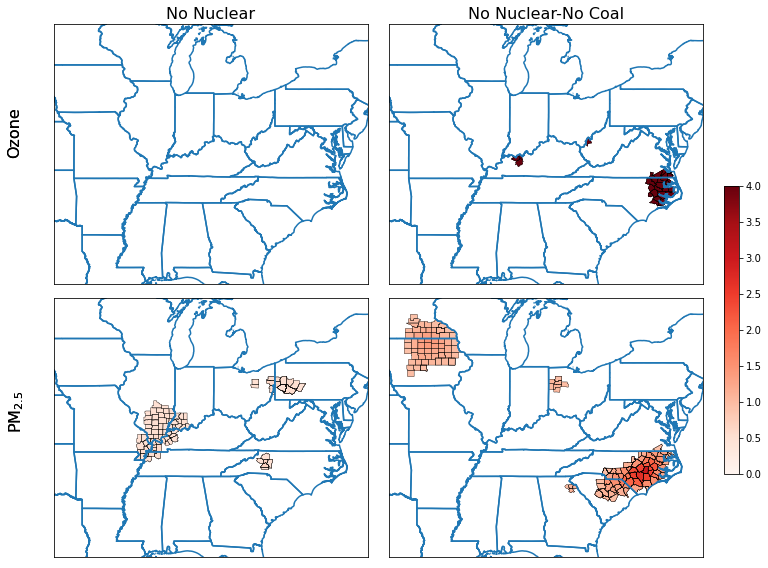

In [43]:
fig, axes = plt.subplots(2,2, figsize = (10,8))
vmin = 0
vmax = 4
for idx, run in enumerate(['nonuc','nonuc_coal']):
    ###OZONE###
    ax = axes[0,idx]
    threshold = combined_df[f'O3_{run}'].mean() + 2*combined_df[f'O3_{run}'].std()
    q = combined_df.loc[combined_df[f'O3_{run}']>threshold].plot(ax = ax, column = f'O3_{run}', legend=False, 
                                             vmin = vmin, vmax = vmax, 
                                             cmap = 'Reds')
    (final_df.loc[final_df[f'O3_{run}']>threshold]).boundary.plot(ax = ax, color = 'k', linewidth = .2)
    states.boundary.plot(ax = ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-96,-74])
    ax.set_ylim(30,46)
    axes[0, 0].annotate(r'Ozone', xy=(-.15, 0.5), xycoords = 'axes fraction', fontsize = 16, rotation = 90)

    ###PM###
    ax = axes[1,idx]
    threshold = combined_df[f'PM25_{run}'].mean() + 2*combined_df[f'PM25_{run}'].std()
    q = combined_df.loc[combined_df[f'PM25_{run}']>threshold].plot(ax = ax, column = f'PM25_{run}', legend=False, 
                                             vmin = vmin, vmax = vmax,  
                                             cmap = 'Reds')
    (final_df.loc[final_df[f'PM25_{run}']>threshold]).boundary.plot(ax = ax, color = 'k', linewidth = .2)
    states.boundary.plot(ax = ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-96,-74])
    ax.set_ylim(30,46)
    axes[1, 0].annotate(r'PM$_{2.5}$', xy=(-.15, 0.5), xycoords = 'axes fraction', fontsize = 16, rotation = 90)
    
    axes[0,1].set_title(f'No Nuclear-No Coal', fontsize = 16)
    axes[0,0].set_title(f'No Nuclear', fontsize = 16)
plt.tight_layout()

# Add single colorbar
cax = fig.add_axes([1.0, 0.17, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.savefig('Figures/at_risk_counties.png', bbox_inches = 'tight', dpi = 150)

# Analysis

In [44]:
def grouped_weighted_avg(values, weights):
    return (values * weights).sum() / weights.sum()

## Total Mortalities by scenario and pollutant

In [45]:
for run in ['nonuc','nonuc_coal']:
    print(final_df[f'Δmortality_O3_mean_{run}'].sum())

613.3403307497344
-52.27136587057892


In [46]:
for run in ['nonuc','nonuc_coal']:
    print(final_df[f'Δmortality_PM_mean_{run}'].sum())

4124.142038186944
4628.526942446534


## Exposure Difference by Coal Containing or Not

In [47]:
for run in ['nonuc','nonuc_coal']:
    print('Near', 'PM', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 3)[f'PM25_{run}'].groupby('County_State').mean(), 
                     final_df.xs(True, level = 3)[f'Population'].groupby('County_State').mean()))
    print('Near', 'O3', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 3)[f'O3_{run}'].groupby('County_State').mean(), 
                     final_df.xs(True, level = 3)[f'Population'].groupby('County_State').mean()))
    

Near PM nonuc
0.22306857112981446
Near O3 nonuc
0.11189917639442735
Near PM nonuc_coal
0.1895168533287608
Near O3 nonuc_coal
-0.20813628889555794


### statistical significance

In [48]:
## statistical significance of the difference between pollution near a coal plant when just nuclear is shut down vs. nuclear and coal are shut down
for run in [True, False]:
    print('near coal', run)
    for poll in ['O3','PM25']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(grouped_weighted_avg(final_df.xs(True, level = 3)[f'{poll}_nonuc_coal'].groupby('County_State').mean(), 
                     final_df.xs(True, level = 3)[f'Population'].groupby('County_State').mean()),
                             grouped_weighted_avg(final_df.xs(True, level = 3)[f'{poll}_nonuc'].groupby('County_State').mean(), 
                     final_df.xs(True, level = 3)[f'Population'].groupby('County_State').mean()),
                             equal_var = False))

near coal True
O3 : 
Ttest_indResult(statistic=nan, pvalue=nan)
PM25 : 
Ttest_indResult(statistic=nan, pvalue=nan)
near coal False
O3 : 
Ttest_indResult(statistic=nan, pvalue=nan)
PM25 : 
Ttest_indResult(statistic=nan, pvalue=nan)


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Mortality Difference by Coal County

In [49]:
for run in ['nonuc', 'nonuc_coal']:
    print(run)
    print('PM, near: ', (final_df.xs(True, level = 3)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(True, level = 3)['Population'].sum())*1e6)
    print('PM, not: ', (final_df.xs(False, level = 3)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(False, level = 3)['Population'].sum())*1e6)
    print('O3, near: ', (final_df.xs(True, level = 3)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(True, level = 3)['Population'].sum())*1e6)
    print('O3, not: ', (final_df.xs(False, level = 3)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(False, level = 3)['Population'].sum())*1e6)

nonuc
PM, near:  8.526684380950407
PM, not:  5.989494329077256
O3, near:  0.40701302051848176
O3, not:  1.108137046333434
nonuc_coal
PM, near:  7.837708635955515
PM, not:  7.159214417862008
O3, near:  -1.0317098228722235
O3, not:  0.15726420506505795


### statistical significance

In [50]:
for poll in ['O3','PM']:
    print(poll, ': ')
    for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
   'Black or African American', 'Hispanic or Latino',
    'White']:
        print(re, ': ')
        for opt in [True]:
            print('coal county, ', opt, ': ')
            print(scipy.stats.ttest_ind(final_df.xs(opt, level = 3).xs(re, level = 1)[f'Δmortality_{poll}_mean_nonuc_coal']/final_df.xs(opt, level = 3).xs(re, level = 1)['Population'],
                                 final_df.xs(opt, level = 3).xs(re, level = 1)[f'Δmortality_{poll}_mean_nonuc']/final_df.xs(opt, level = 3).xs(re, level = 1)['Population'],
                                #nan_policy = 'omit',
                                 equal_var = True))

O3 : 
American Indian or Alaska Native : 
coal county,  True : 
Ttest_indResult(statistic=nan, pvalue=nan)
Asian or Pacific Islander : 
coal county,  True : 
Ttest_indResult(statistic=nan, pvalue=nan)
Black or African American : 
coal county,  True : 
Ttest_indResult(statistic=nan, pvalue=nan)
Hispanic or Latino : 
coal county,  True : 
Ttest_indResult(statistic=nan, pvalue=nan)
White : 
coal county,  True : 
Ttest_indResult(statistic=nan, pvalue=nan)
PM : 
American Indian or Alaska Native : 
coal county,  True : 
Ttest_indResult(statistic=0.6278616795610041, pvalue=0.5312875830040866)
Asian or Pacific Islander : 
coal county,  True : 
Ttest_indResult(statistic=0.9974444726802334, pvalue=0.31994998247517925)
Black or African American : 
coal county,  True : 
Ttest_indResult(statistic=-0.4396709481876, pvalue=0.6604267069202794)
Hispanic or Latino : 
coal county,  True : 
Ttest_indResult(statistic=-1.0107332329779617, pvalue=0.31303583784022343)
White : 
coal county,  True : 
Ttest_indR

## Exposure Difference by Nuclear or Not Adjacent County

In [51]:
for run in ['nonuc','nonuc_coal']:
    print('PM25')
    print('Near', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 2)[f'PM25_{run}'],
                  final_df.xs(True, level = 2)[f'Population']))
    print('Not', run)
    print(grouped_weighted_avg(final_df.xs(False, level = 2)[f'PM25_{run}'],
                  final_df.xs(True, level = 2)[f'Population']))
    print('O3')
    print('Near', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 2)[f'O3_{run}'],
                  final_df.xs(True, level = 2)[f'Population']))
    print('Not', run)
    print(grouped_weighted_avg(final_df.xs(False, level = 2)[f'O3_{run}'],
                  final_df.xs(True, level = 2)[f'Population']))

PM25
Near nonuc
0.2137366300664036
Not nonuc
0.0012910732975008315
O3
Near nonuc
0.1700660380945826
Not nonuc
0.0037142636163204038
PM25
Near nonuc_coal
0.30777029889129986
Not nonuc_coal
0.001028767185907417
O3
Near nonuc_coal
-0.28831847498743357
Not nonuc_coal
-0.006230295299264331


### statistical significance

In [47]:
## t test for the different runs for near nuclear vs. not near nuclear
for run in ['nonuc','nonuc_coal']:
    print(run)
    for poll in ['O3','PM25']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(final_df.xs(True, level = 2)[f'{poll}_{run}'].groupby('County_State').mean(),
                             final_df.xs(False, level = 2)[f'{poll}_{run}'].groupby('County_State').mean(),
                             equal_var = False))

nonuc
O3 : 
Ttest_indResult(statistic=9.87769334146311, pvalue=2.0476369750376188e-22)
PM25 : 
Ttest_indResult(statistic=13.412975613697304, pvalue=1.8939623821993606e-39)
nonuc_coal
O3 : 
Ttest_indResult(statistic=10.01155746683851, pvalue=8.407966566700795e-23)
PM25 : 
Ttest_indResult(statistic=18.148290869314028, pvalue=8.421616520040696e-66)


### Mortality Difference by Nuclear or Not Adjacent County

In [45]:
for run in ['nonuc', 'nonuc_coal']:
    print(run)
    print('PM, near: ', (final_df.xs(True, level = 2)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(True, level = 2)['Population'].sum())*1e6)
    print('PM, not: ', (final_df.xs(False, level = 2)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(False, level = 2)['Population'].sum())*1e6)
    print('O3, near: ', (final_df.xs(True, level = 2)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(True, level = 2)['Population'].sum())*1e6)
    print('O3, not: ', (final_df.xs(False, level = 2)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(False, level = 2)['Population'].sum())*1e6)

nonuc
PM, near:  8.173076366419899
PM, not:  5.1145071512032745
O3, near:  0.864578473301517
O3, not:  1.2035558292196402
nonuc_coal
PM, near:  11.875800619723273
PM, not:  3.4985468246992846
O3, near:  0.015346492060915177
O3, not:  0.35832740593610746


In [51]:
final_df.xs(True, level = 2)[f'Δmortality_PM_mean_nonuc'].sum()

2350.9113564691897

### statistical significance

In [55]:
## t test for the different runs for near nuclear vs. not near nuclear
for run in ['nonuc','nonuc_coal']:
    print(run)
    for poll in ['O3','PM']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(final_df.xs(True, level = 2)[f'Δmortality_{poll}_mean_{run}']/final_df.xs(True, level = 2)['Population'],
                             final_df.xs(False, level = 2)[f'Δmortality_{poll}_mean_{run}']/final_df.xs(False, level = 2)['Population'],
                            nan_policy = 'omit',
                             equal_var = False))

nonuc
O3 : 
Ttest_indResult(statistic=-3.317206265234071, pvalue=0.0009208275127103332)
PM : 
Ttest_indResult(statistic=8.132969147943413, pvalue=5.332655982739059e-16)
nonuc_coal
O3 : 
Ttest_indResult(statistic=-1.9746406424200464, pvalue=0.04837947278934813)
PM : 
Ttest_indResult(statistic=17.704175681018256, pvalue=8.391642716196898e-67)


## Plot the counties with Nuclear Plants near 

In [50]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)

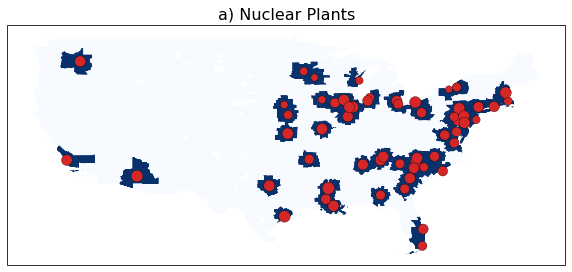

In [51]:
fig, ax = plt.subplots(figsize=[10,5], subplot_kw={'projection':ccrs.LambertConformal()})
mod_factor = 80000

###### Nuclear Plot ######

plants = ['Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']


###### Create axes ######
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) Nuclear Plants', fontsize = 16)

###### plot #######
final_df.reset_index().plot(ax = ax, column = 'nuclear_adjacent', cmap='Blues' )


#create lat and lon 
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c='C3', s = size, linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)



## Overall Difference in Exposure by Race

In [82]:

for poll in ['PM25_nonuc','PM25_nonuc_coal','O3_nonuc','O3_nonuc_coal']:
    print('\n', poll, '\n')
    for re in ['Black or African American', 'Asian or Pacific Islander',
        'Hispanic or Latino',
        'White','American Indian or Alaska Native']:
        print(re, grouped_weighted_avg(final_df.xs(re, level =1)[poll], 
                           final_df.xs(re, level =1)[f'Population']))


 PM25_nonuc 

Black or African American 0.1997162183981722
Asian or Pacific Islander 0.1176442852974017
Hispanic or Latino 0.09406602767989646
White 0.17129894434059598
American Indian or Alaska Native 0.0739178324490353

 PM25_nonuc_coal 

Black or African American 0.2648246381320841
Asian or Pacific Islander 0.13860303497366114
Hispanic or Latino 0.07799617080541585
White 0.18275032388245546
American Indian or Alaska Native 0.08797888422138646

 O3_nonuc 

Black or African American 0.2842914164727253
Asian or Pacific Islander 0.09853471296659562
Hispanic or Latino 0.07611381741771836
White 0.18179032846191953
American Indian or Alaska Native 0.11855351074317245

 O3_nonuc_coal 

Black or African American -0.12054522007963267
Asian or Pacific Islander -0.38277477721454667
Hispanic or Latino -0.2408013677595638
White -0.11644970536913561
American Indian or Alaska Native -0.15650670244268175


## Maps of Different County Exposure by State

fig, axes = plt.subplots(5, 2, figsize = (10,15))
for idx_re, re in enumerate(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']):
    for idx_run, run in enumerate(['nonuc_coal','nonuc']):
        ax = axes[idx_re, idx_run]
        final_df.xs(re, level = 1).plot( f'PM25_{run}', ax = ax, legend = False, vmin = 0, vmax = 1.5)
        #combined_df.plot(column = re, legend = True, vmin = 1e4, vmax = 1e5)
        axes[0, 0].set_title('No Nuclear-No Coal', fontsize = 16)
        axes[0, 1].set_title('No Nuclear', fontsize = 16)
        axes[idx_re, 0].annotate(re, xy = (-0.1, 0.05), xycoords = 'axes fraction', rotation = 90)
# Add single colorbar
cax = fig.add_axes([1.05, 0.4, 0.02, 0.2])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin = 0, vmax = 1.5))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, extend = 'both')
cbar.ax.set_ylabel(r'PM$_{2.5}$ ($\mu g/m^3$)', fontsize = 16)
plt.tight_layout()
plt.suptitle(r'WONDER Aggregated PM$_{2.5}$ ($\mu g/m^3$)', fontsize = 24) 
plt.savefig('Figures/PM_exposure_wonder.png', dpi = 150, bbox_inches = 'tight')

fig, axes = plt.subplots(5, 2, figsize = (10,15))
for idx_re, re in enumerate(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']):
    for idx_run, run in enumerate(['nonuc_coal','nonuc']):
        ax = axes[idx_re, idx_run]
        final_df.xs(re, level = 1).plot( f'O3_{run}', ax = ax, legend = False, vmin = 0, vmax = 4)
        #combined_df.plot(column = re, legend = True, vmin = 1e4, vmax = 1e5)
        axes[0, 0].set_title('No Nuclear-No Coal', fontsize = 16)
        axes[0, 1].set_title('No Nuclear', fontsize = 16)
        axes[idx_re, 0].annotate(re, xy = (-0.1, 0.05), xycoords = 'axes fraction', rotation = 90)
# Add single colorbar
cax = fig.add_axes([1.05, 0.4, 0.02, 0.2])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin = 0, vmax = 4))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, extend = 'both')
cbar.ax.set_ylabel(r'O$_{3}$ (ppb)', fontsize = 16)
plt.tight_layout()
plt.suptitle(r'WONDER Aggregated O$_{3}$ (ppb)', fontsize = 24) 
plt.savefig('Figures/O3_exposure_wonder.png', dpi = 150, bbox_inches = 'tight')

### Number of People

In [65]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re, final_df.xs(re, level =1)['Population'].sum())

American Indian or Alaska Native 3104989.0
Asian or Pacific Islander 18212624.0
Black or African American 44396552.0
Hispanic or Latino 54750157.0
White 251648172.5


## Overall Difference in Mortality by Race

In [85]:
CI = 'mean'
for re in ['Black or African American', 'Asian or Pacific Islander',
        'Hispanic or Latino',
        'White','American Indian or Alaska Native']:
    for run in ['nonuc_coal']:
        print(re, run)
        print('PM25: ', (final_df.xs(re, level = 1)[f'Δmortality_PM_{CI}_{run}'].sum()/
               final_df.xs(re, level = 1)['Population'].sum())*1e6)
        #print('Ozone: ', (final_df.xs(re, level = 1)[f'Δmortality_O3_{CI}_{run}'].sum()/
               #final_df.xs(re, level = 1)['Population'].sum())*1e6)

Black or African American nonuc_coal
PM25:  39.48837550302556
Asian or Pacific Islander nonuc_coal
PM25:  3.4063735264840074
Hispanic or Latino nonuc_coal
PM25:  1.7411997621418258
White nonuc_coal
PM25:  10.735723905726644
American Indian or Alaska Native nonuc_coal
PM25:  5.276657696122915


In [143]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re, 100-(len(np.unique(final_df.xs(re, level = 1).reset_index()['County_State']))/len(np.unique(final_df.reset_index()['County_State'])))*100)

American Indian or Alaska Native 88.88888888888889
Asian or Pacific Islander 86.64059954382535
Black or African American 55.55555555555556
Hispanic or Latino 72.62952101661779
White 0.1629195177582261
